<a href="https://colab.research.google.com/github/Carapet07/Data-Science-projects/blob/main/YouTube_comments_sentiments_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import os, pathlib, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization, Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
!kaggle datasets download atifaliak/youtube-comments-dataset
!unzip youtube-comments-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/atifaliak/youtube-comments-dataset
License(s): DbCL-1.0
youtube-comments-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  youtube-comments-dataset.zip
replace YoutubeCommentsDataSet.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [24]:
df_path = 'YoutubeCommentsDataSet.csv'

df = pd.read_csv(df_path)
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


## Visualize the Data

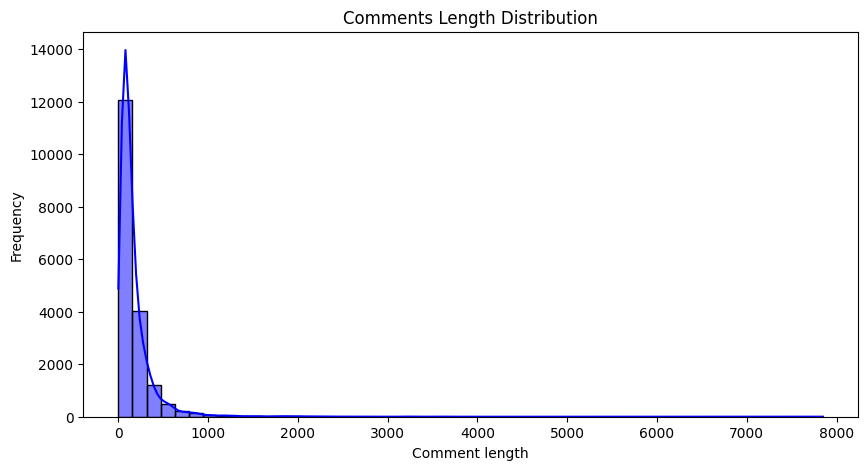

In [25]:
df['comment_length'] = df['Comment'].apply(lambda x: len(str(x)))

plt.figure(figsize=(10, 5))
sns.histplot(df['comment_length'], bins=50, kde=True, color='blue')
plt.title('Comments Length Distribution')
plt.xlabel('Comment length')
plt.ylabel('Frequency')
plt.show()

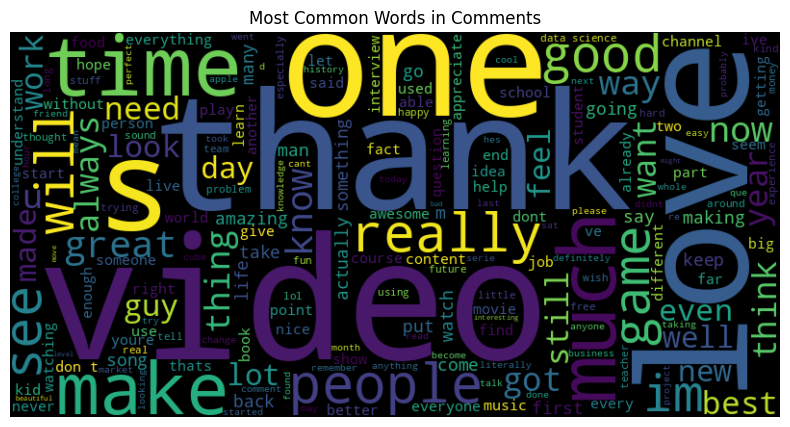

In [26]:
from wordcloud import WordCloud

text = " ".join(df["Comment"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Comments")
plt.show()


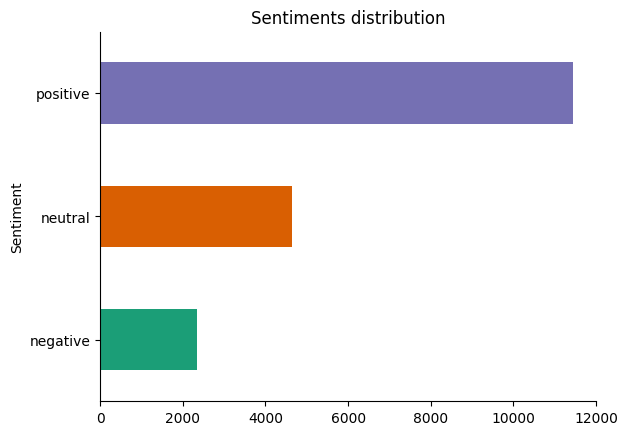

In [27]:
df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Sentiments distribution');

<ipython-input-28-74d0419a6bb7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Sentiment"], y=df["comment_length"], palette="Set2")


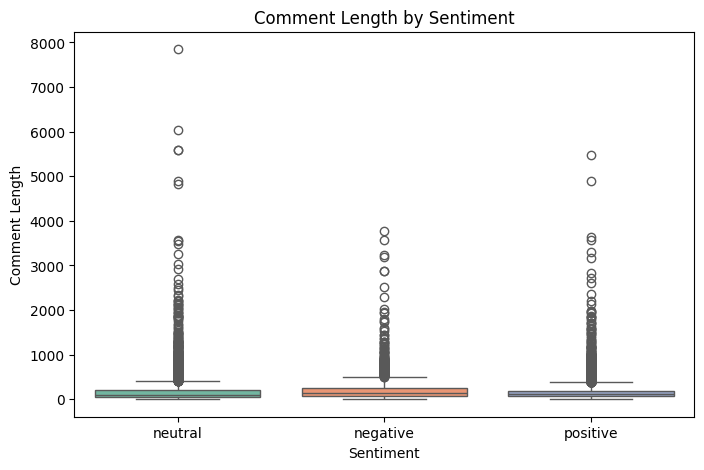

In [28]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Sentiment"], y=df["comment_length"], palette="Set2")
plt.xlabel("Sentiment")
plt.ylabel("Comment Length")
plt.title("Comment Length by Sentiment")
plt.show()


In [29]:
print(f"{df.info()} \n{df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Comment         18364 non-null  object
 1   Sentiment       18408 non-null  object
 2   comment_length  18408 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 431.6+ KB
None 
(18408, 3)


In [30]:
mean_sentence_length = (df['Comment']).apply(lambda x: len(str(x).split()))

mean_length = mean_sentence_length.mean()
print(mean_length)

32.8563124728379


Here we see that mean sentence length is 33. Thus if we follow the rule of thumb for deciding wheather to go with a bag-of-words model or a sequence moel(https://developers.google.com/machine-learning/guides/text-classification) ther is a high probability that bag-of-words model will fit the best in our case. But why?

It turns out that when approaching a new text-classification task, you should pay close attention to the ratio between the number of samples in your training data and the mean number of words per sample. If that ratio is small—less than 1,500—then the bag-of-bigrams model will perform better (and as a bonus, it will be much faster to train and to iterate on too). If that ratio is higher than 1,500, then you should go with a sequence model. In other words, sequence models work best when lots of training data is available and when each sample is relatively short.

So if you’re classifying 1,000-word long documents, and you have 100,000 of them (a ratio of 100), you should go with a bigram model. If you’re classifying tweets that are 40 words long on average, and you have 50,000 of them (a ratio of 1,250), you should also go with a bigram model. But if you increase your dataset size to 500,000 tweets (a ratio of 12,500), go with a Transformer encoder. What about the YouTube sentiment analysis task? We have 18408 training samples and an average word count of 33, so our rule of thumb points toward a bigram model

### Converting labels Neutral, Pos and Neg into integers 0, 1 and 2

In [31]:
df['Sentiment'] = df['Sentiment'].replace({'neutral': 0, 'positive': 1, 'negative': 2})

<ipython-input-31-4da472952139>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sentiment'] = df['Sentiment'].replace({'neutral': 0, 'positive': 1, 'negative': 2})


In [32]:
! nltk.download('stopwords')


/bin/bash: -c: line 1: syntax error near unexpected token `'stopwords''
/bin/bash: -c: line 1: ` nltk.download('stopwords')'


In [33]:
# Drop NaN rows
df = df.dropna(subset=['Comment'])

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Example usage
df['Comment'] = df['Comment'].apply(remove_stopwords)
df.head()

,Comment,Sentiment,comment_length
0,lets forget apple pay 2014 required brand new ...,0,317
1,nz 50 retailers don’t even contactless credit ...,2,163
2,forever acknowledge channel help lessons ideas...,1,183
3,whenever go place doesn’t take apple pay doesn...,2,450
4,apple pay convenient secure easy use used kore...,1,135


### Apply word embeddings

In [34]:
X = df['Comment']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2025)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=2025)

### Apply text vectorizer TF-IDF

In [35]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df['Comment'])

print(f'Total number of unique words {len(vectorizer.vocabulary_)}')

Total number of unique words 39743


The total number of unique words occurence in the dataset is 39743
The best practice is to chose 10-20% of all unique words for max_features parameters, so I will take 6000

In [36]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)

X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf = vectorizer.transform(X_test)

1st model: a simple Dense model

In [37]:
inputs = keras.Input(shape=(X_train_tfidf.shape[1],))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.compile(
    loss='mse',
    optimizer='adam',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint('lstm_model.keras',
                                    save_best_only=True)
]

history=model.fit(X_train_tfidf, y_train, validation_data=(X_valid_tfidf, y_valid),
                  epochs=10,
                  callbacks=callbacks)

model = keras.models.load_model('lstm_model.keras')
print(f"Test accuracy: {model.evaluate(X_test_tfidf, y_test)[1]:.3f}")

Epoch 1/10
  2/368 ━━━━━━━━━━━━━━━━━━━━ 6:40 1s/step - accuracy: 0.6406 - loss: 0.5281 

RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL InternalError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/errors_impl.py(462): __init__
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/execute.py(53): quick_execute
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/context.py(1683): call_function
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(251): call_flat
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(216): call_preflattened
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/concrete_function.py(1322): _call_flat
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py(139): call_function
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(878): _call
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(833): __call__
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py(219): function
  /usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py(371): fit
  /usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py(117): error_handler
  <ipython-input-37-8276bf7c94c1>(20): <cell line: 0>
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3553): run_code
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3473): run_ast_nodes
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3257): run_cell_async
  /usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py(78): _pseudo_sync_runner
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3030): _run_cell
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(2975): run_cell
  /usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py(528): run_cell
  /usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py(383): do_execute
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(730): execute_request
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(406): dispatch_shell
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(499): process_one
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(510): dispatch_queue
  /usr/lib/python3.11/asyncio/events.py(84): _run
  /usr/lib/python3.11/asyncio/base_events.py(1936): _run_once
  /usr/lib/python3.11/asyncio/base_events.py(608): run_forever
  /usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py(205): start
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py(712): start
  /usr/local/lib/python3.11/dist-packages/traitlets/config/application.py(992): launch_instance
  /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py(37): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main


Now let's try some popular models that deal great with classification tasks
1. LogisticRegression
2. Random Forest
3. Naive Bayes
4. Support Vector Machine
5. XGBoost

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs'),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
    'NaiveBayes': MultinomialNB(alpha=1.0),
    'SVM': SVC(kernel='linear', C=1.0, probability=True),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
  clf = model.fit(X_train_tfidf, y_train)
  y_pred = clf.predict(X_test_tfidf)
  acc = accuracy_score(y_test, y_pred)
  print(f"{name} Accuracy: {acc:.3f}\n")
  results[name] = acc

best_model = max(results, key=results.get)
print(f"Best model: {best_model} with accuracy {results[best_model]:.3f}")

Now let's try a more complex approaches

I will apply TextVectorization and create new training, validation, and test sets. Each word will have an embedding vector representing its meaning, and positional encoding will be applied to capture word order. This allows the model to understand both the meaning of words and their positions within a sentence.

TextVectorization(output_mode='int') converts words into numbers starting from 1. It learns the vocabulary from X_train, if an unknown word appears it is assigned the ID 0 which represents the OOV (Out-of-Vocabulary)

Finally I will use two Deep Learning models: LSTM and a Transformer

In [42]:
# Apply Text vectorization

max_features = 10000
output_sequence_length = 40

vectorizer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=output_sequence_length
)

vectorizer.adapt(X_train)

X_train_vec = vectorizer(X_train)
X_valid_vec = vectorizer(X_valid)
X_test_vec = vectorizer(X_test)

In [39]:
embedding_layer = Embedding(input_dim=max_features, output_dim=128, mask_zero=True)

inputs = keras.Input(shape=(None, ), dtype='int64')
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(64, activation='relu', return_sequences=True))(embedded)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(32, activation='relu', return_sequences=False))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.compile(
    loss='mse',
    optimizer='rmsprop',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint('embedding_model.keras',
                                    save_best_only=True)
]

In [ ]:
model.fit(X_train_vec, y_train, validation_data=(X_valid_vec, y_valid),
          epochs=10, callbacks=callbacks);

Now let's implement a transformer model

In [49]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads
        )
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False, return_attention=False):
        attn_output, attn_weights = self.attention(inputs, inputs, return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        if return_attention:
            return out2, attn_weights
        return out2

class PositionalEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[-1], delta=1)
        return self.token_emb(inputs) + self.pos_emb(positions)

In [51]:
vocab_size = 10000
maxlen = 40
embed_dim = 128
num_heads = 2
ff_dim = 32


inputs = keras.Input(shape=(None,), dtype='int64')
x = PositionalEmbedding(maxlen, vocab_size, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint('full_transformer_encoder.keras',
                                    save_best_only=True)
]

history=model.fit(X_train_vec, y_train,
                  validation_data=(X_valid_vec, y_valid),
                  epochs=10,
                  callbacks=callbacks)

model = keras.models.load_model('full_transformer_encoder.keras',
                                custom_objects=({
                                    'TransformerBlock': TransformerBlock,
                                    'PositionalEmbedding': PositionalEmbedding,
                                }))
print(f"Test accuracy {model.evaluate(y_test)[1]:.3f}")

Epoch 1/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.6273 - loss: 0.3662 - val_accuracy: 0.6666 - val_loss: 0.3257
Epoch 2/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6474 - loss: 0.3408 - val_accuracy: 0.6666 - val_loss: 0.3138
Epoch 3/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6799 - loss: 0.3011 - val_accuracy: 0.6734 - val_loss: 0.3159
Epoch 4/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6972 - loss: 0.2873 - val_accuracy: 0.6713 - val_loss: 0.3069
Epoch 5/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7249 - loss: 0.2597 - val_accuracy: 0.6720 - val_loss: 0.3098
Epoch 6/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7429 - loss: 0.2482 - val_accuracy: 0.6781 - val_loss: 0.3134
Epoch 7/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7531 - loss: 0.2378 - val_accuracy: 0.6774 - val_loss: 0.3117
Epoch 8/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7758 - loss: 0.2170 - val_accuracy: 

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'RMSprop', 'config': {'name': 'rmsprop', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}, 'registered_name': None}, 'loss': 'mse', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: <class '__main__.PositionalEmbedding'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'PositionalEmbedding', 'config': {'maxlen': 40, 'vocab_size': 10000, 'embed_dim': 128, 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'PositionalEmbedding', 'build_config': {'input_shape': [None, None]}, 'name': 'positional_embedding_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, None], 'dtype': 'int64', 'keras_history': ['input_layer_13', 0, 0]}}], 'kwargs': {}}]}.

Exception encountered: Error when deserializing class 'PositionalEmbedding' using config={'maxlen': 40, 'vocab_size': 10000, 'embed_dim': 128, 'trainable': True, 'dtype': 'float32'}.

Exception encountered: PositionalEmbedding.__init__() got an unexpected keyword argument 'trainable'